# Analyzer for task 1

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import statistics as stats
import re
import numpy as np

In [2]:
def read_and_parse_data_files(folder: Path) -> pd.DataFrame:
    tmp_pandas_list = []

    for file in folder.glob('*.csv'):
        dataset = pd.read_csv(file, delimiter=',')
        
        # Convert time columns to floats
        dataset['send time'] = dataset['send time'].apply(lambda x: float(x.split(':')[-1]))
        dataset['answer time'] = dataset['answer time'].apply(lambda x: float(x.split(':')[-1]))
        
        # Insert mean values
        dataset['send time (mean)'] = dataset['send time'].mean()
        dataset['answer time (mean)'] = dataset['answer time'].mean()
        
        tmp_pandas_list.append(dataset)
        
    return pd.concat(tmp_pandas_list, axis=0, ignore_index=True)

In [3]:
data = read_and_parse_data_files(Path('.'))

In [4]:
print(f'Total data collected: {data.shape}')
print(f'Different test approaches: {len(data["test group"].drop_duplicates())}')

Total data collected: (30705, 9)
Different test approaches: 10


In [5]:
data

,test group,test name,loop counter,send time,answer time,message,trace hops,send time (mean),answer time (mean)
0,andreas-ubuntu-athome,andreas-ubuntu-athome-5,0,0.000043,0.010783,27,11,0.000057,0.011231
1,andreas-ubuntu-athome,andreas-ubuntu-athome-5,1,0.000051,0.010908,27,11,0.000057,0.011231
2,andreas-ubuntu-athome,andreas-ubuntu-athome-5,2,0.000051,0.012105,27,11,0.000057,0.011231
3,andreas-ubuntu-athome,andreas-ubuntu-athome-5,3,0.000056,0.011202,27,11,0.000057,0.011231
4,andreas-ubuntu-athome,andreas-ubuntu-athome-5,4,0.000082,0.011159,27,11,0.000057,0.011231
...,...,...,...,...,...,...,...,...,...
30700,marvin-wsl-pine-vpn,marvin-wsl-pine-vpn-1000,995,0.000024,0.014098,912,30,0.000029,0.015663
30701,marvin-wsl-pine-vpn,marvin-wsl-pine-vpn-1000,996,0.000023,0.014981,912,30,0.000029,0.015663
30702,marvin-wsl-pine-vpn,marvin-wsl-pine-vpn-1000,997,0.000023,0.014235,912,30,0.000029,0.015663
30703,marvin-wsl-pine-vpn,marvin-wsl-pine-vpn-1000,998,0.000021,0.017866,912,30,0.000029,0.015663


## Details about traceroute

In [6]:
hops_group = data.groupby('test name')['trace hops'].max().reset_index().sort_values(['trace hops'])

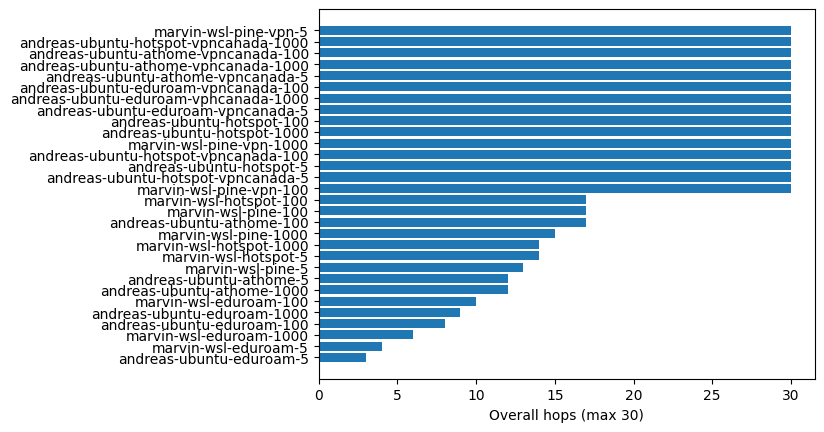

In [7]:
fig, ax = plt.subplots()
ax.barh(hops_group['test name'], hops_group['trace hops'])
ax.set_xlabel('Overall hops (max 30)')     
plt.show()

Example trace route with over 30 hops

In [8]:
with open('andreas-ubuntu-hotspot-20_23_45_888841.csv.trace', 'r') as file: print(file.read()) 

traceroute to 130.243.124.183 (130.243.124.183), 30 hops max, 60 byte packets
 1  _gateway (172.20.10.1)  4.307 ms  4.284 ms  4.278 ms
 2  * * *
 3  * * *
 4  * * *
 5  * * *
 6  * * *
 7  * * *
 8  ipservice-092-214-120-018.092.214.pools.vodafone-ip.de (92.214.120.18)  76.140 ms  88.859 ms  88.853 ms
 9  nordunet.sara1.nl-ix.net (193.239.116.53)  92.783 ms  92.777 ms  92.770 ms
10  nordunet.sara1.nl-ix.net (193.239.116.53)  96.327 ms  92.758 ms  96.314 ms
11  dk-esbj.nordu.net (109.105.97.74)  98.237 ms  101.029 ms  89.044 ms
12  dk-bal2.nordu.net (109.105.98.24)  94.362 ms  90.857 ms  87.243 ms
13  lnd88-r1.sunet.se (109.105.102.3)  82.891 ms  82.842 ms  82.355 ms
14  vaxjo-vxj-r1.sunet.se (130.242.4.63)  85.096 ms  85.080 ms  95.341 ms
15  jonkoping-jkg-r1.sunet.se (130.242.4.54)  90.327 ms  91.812 ms  88.449 ms
16  skovde-ske109-r1.sunet.se (130.242.4.43)  90.752 ms  93.287 ms  98.991 ms
17  orebro-lba-r1.sunet.se (130.242.4.32)  112.782 ms  90.372 ms  81.982 ms
18  oru1.sunet.se (

## Mean times over different test setups

In [9]:
avg_group = data.groupby('test name')['answer time (mean)'].max().reset_index().sort_values(['answer time (mean)'])

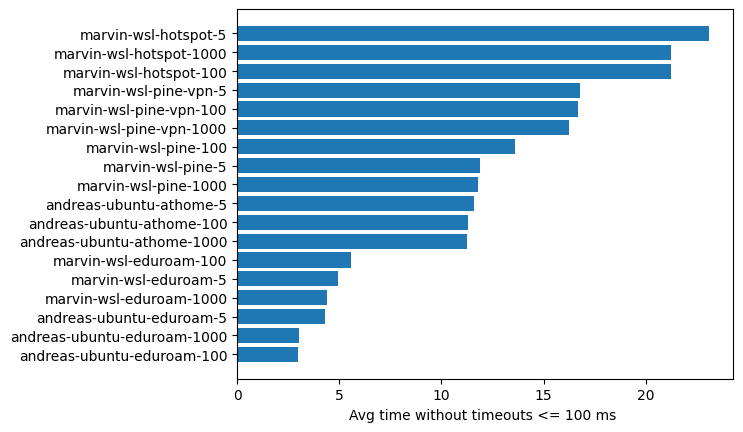

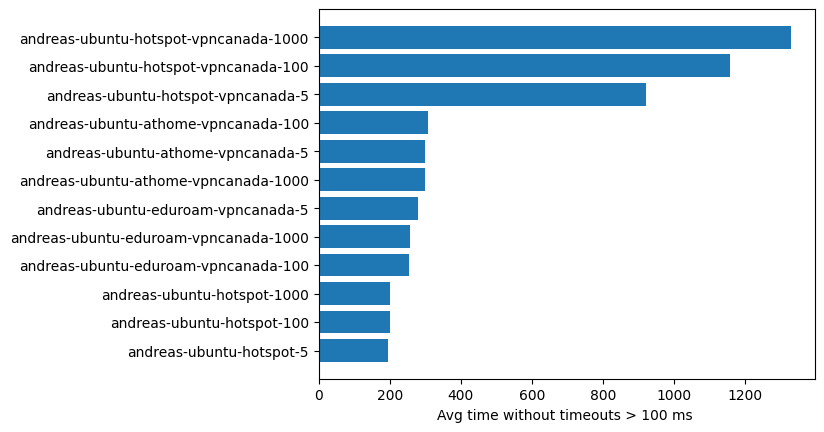

In [10]:
avg_group['answer time (mean)'] *= 1000

avg_group_small = avg_group[avg_group['answer time (mean)'] <= 100]
fig, ax, = plt.subplots()
ax.barh(avg_group_small['test name'], avg_group_small['answer time (mean)'])
ax.set_xlabel('Avg time without timeouts <= 100 ms ')
plt.show()

avg_group_big = avg_group[avg_group['answer time (mean)'] > 100]
fig, bx = plt.subplots()
bx.barh(avg_group_big['test name'], avg_group_big['answer time (mean)'])
bx.set_xlabel('Avg time without timeouts > 100 ms ')
plt.show()


## Statistics about timed out packages

In [11]:
timed_out = data[data['message'] == 'timed out']
tests_with_time_out = data[data['test name'].isin(timed_out['test name'].drop_duplicates().tolist())]

print(f'Over {data.shape[0]} messages timed {timed_out.shape[0]} out!')

Over 30705 messages timed 458 out!


In [12]:
listed_groups = tests_with_time_out['test name'].drop_duplicates().tolist()

print(f'Timeouts in {len(listed_groups)} of {len(data["test name"].drop_duplicates())} test runs!')

Timeouts in 14 of 30 test runs!
